In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 9)

# Assignment 1

**IMPORTANT**: When finished all problems, rerun your entire notebook by clicking `Kernel > Restart Kernel and Run All Cells` to make sure your notebook runs correctly.

## 1. Sequential Labeling

In this problem, you will implement a system that labels objects in binary images and compute their geometric properties.

Let's first load our sample image and display it.

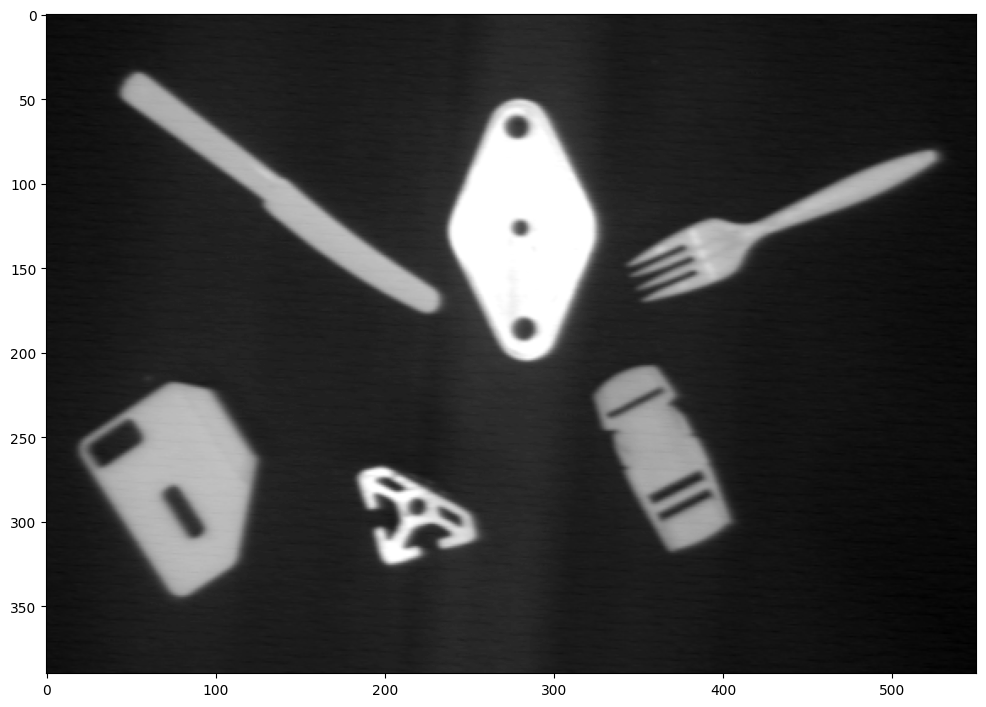

In [2]:
img = plt.imread('data/many_objects_2.png')

plt.imshow(img, cmap='gray')
plt.show()

### 1a. Image Binarization (10 points)

Implement the following function that converts a grayscale image to a binary one by thresholding the pixel intensities. Each element in the output array must be a Boolean value where `True` indicates that the intensity of the corresponding pixel in the input is greater than or equal to the threshold value. You should be able to implement this without using `for`-loops.

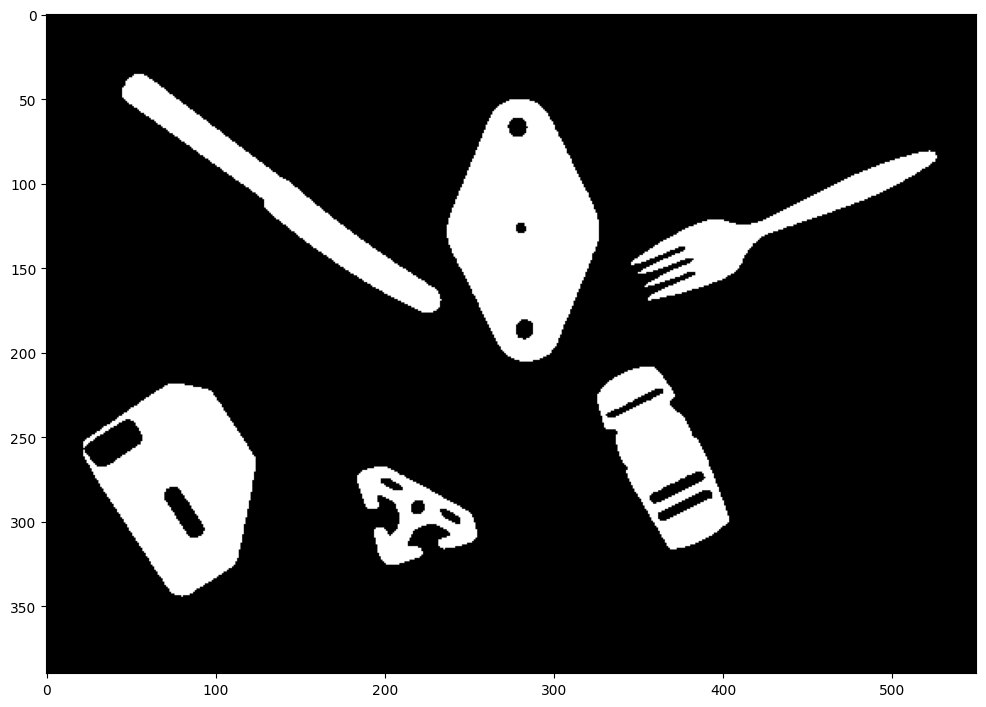

In [3]:
def binarize(gray_img, thresh_val):
    """Converts a grayscale image to a binary image by thresholding.
    
    Args:
    - gray_img: H x W array representing a grayscale image.
    - thresh_val: Threshold value.
    
    Returns:
    - binary_img: H x W Boolean array representing the thresholded image.
    """
    # TODO
    binary_img = gray_img > thresh_val
    return binary_img

binary_img = binarize(img, thresh_val=0.5)

plt.imshow(binary_img, cmap='gray')
plt.show()

### 1b. Label Connected Regions (30 points)

Implement the sequential labeling algorithm in the following function. The function takes a binary image as input and returns an array of the same size. The output array should have data type `int`, where each element is an object label. For example, all background pixels have value 0, all pixels of object 1 has value 1, etc.

Recall from the slides that you may want to do the labeling in two passes. In the first pass, pixels are assigned labels based on the labels of their neighbors. (Be careful when handling pixels near the image boundaries.) This labeling process may result in the same area having multiple labels, which is resolved in the second pass. You are free to choose how to resolve equivalent labels. The union-find data structure is especially suitable for this purpose. If you want to implement helper classes or functions, feel free to add them outside the function body.

In [4]:
class UnionFind:
    def __init__(self, size):
        self.parent = [i for i in range(size)]  
        self.rank = [0] * size  

    def find(self, x):
        """Finds the representative of the set that x is an element of."""
        if self.parent[x] != x: 
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """Unites the sets that x and y are elements of."""
        rootX = self.find(x)
        rootY = self.find(y)
        
        if rootX != rootY:  
            if self.rank[rootX] > self.rank[rootY]:  
                self.parent[rootY] = rootX
            elif self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
            else:
                self.parent[rootY] = rootX
                self.rank[rootX] += 1

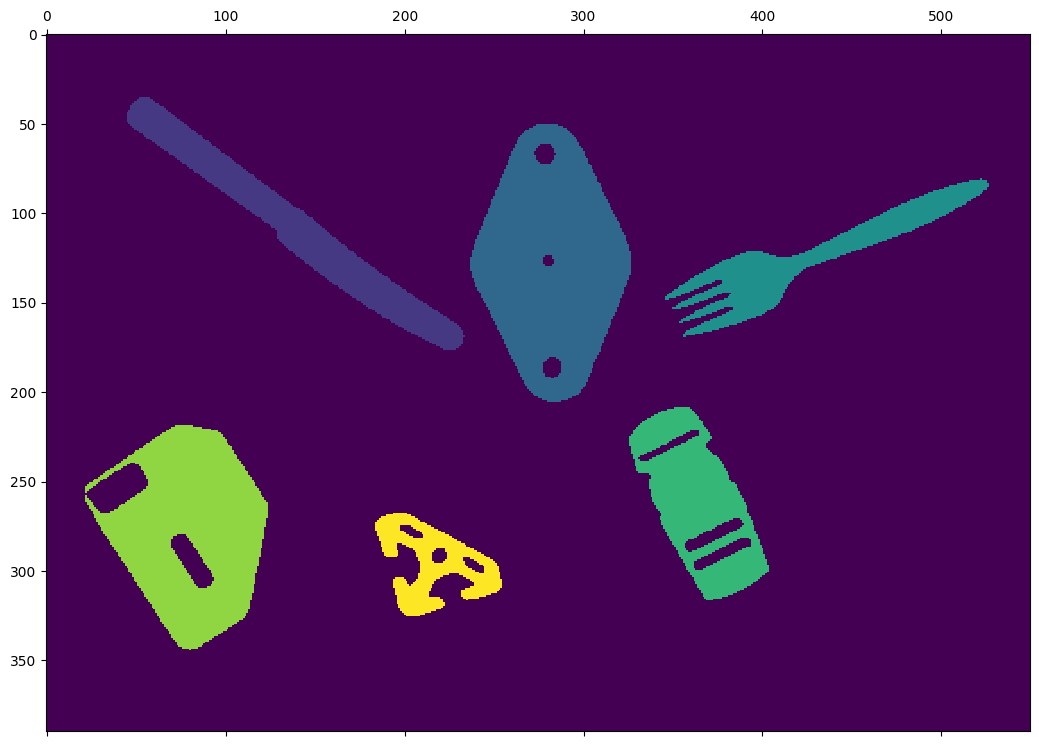

Found 6 objects in image.


In [5]:
def label(binary_img):
    """Label disconnected regions in a binary image.
    
    Args:
    - binary_img: H x W Boolean array representing a binary image where `False`
        indicates background while `True` indicates object regions.
    
    Returns:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    """
    # TODO
    h, w = binary_img.shape
    label_img = np.zeros((h, w), dtype=int)
    uf = UnionFind(h * w)
    label = 1

    for y in range(h):
        for x in range(w):
            if binary_img[y, x]:
                if y > 0 and binary_img[y-1, x]:
                    uf.union(y*w + x, (y-1)*w + x)
                if x > 0 and binary_img[y, x-1]:
                    uf.union(y*w + x, y*w + x-1)
                label_img[y, x] = label
                label += 1
            if y > 0 and x > 0 and binary_img[y-1, x-1]:
                uf.union(y*w + x, (y-1)*w + x-1)
            if y > 0 and x < w-1 and binary_img[y-1, x+1]:
                uf.union(y*w + x, (y-1)*w + x+1)
    
    for y in range(h):
        for x in range(w):
            if binary_img[y, x]:
                label_img[y, x] = uf.find(y*w + x)
    
    unique_labels = np.unique(label_img)
    label_map = {l: i for i, l in enumerate(unique_labels)}
    for i, l in enumerate(unique_labels):
        label_img[label_img == l] = i

    
    return label_img

label_img = label(binary_img)
plt.matshow(label_img)
plt.show()

obj_count = len(np.unique(label_img)) - 1
print(f"Found {obj_count} objects in image.")

### 1c. Calculate Geometric Attributes (10 points)

In the cell below, calculate the geometric attributes (center, orientation, second moment) of each object. A code snippet has been provided to visualize these attributes. To be specific, for each object, we mark the center of the object, and draws an ellipse having the same orientation and second moments around the center.

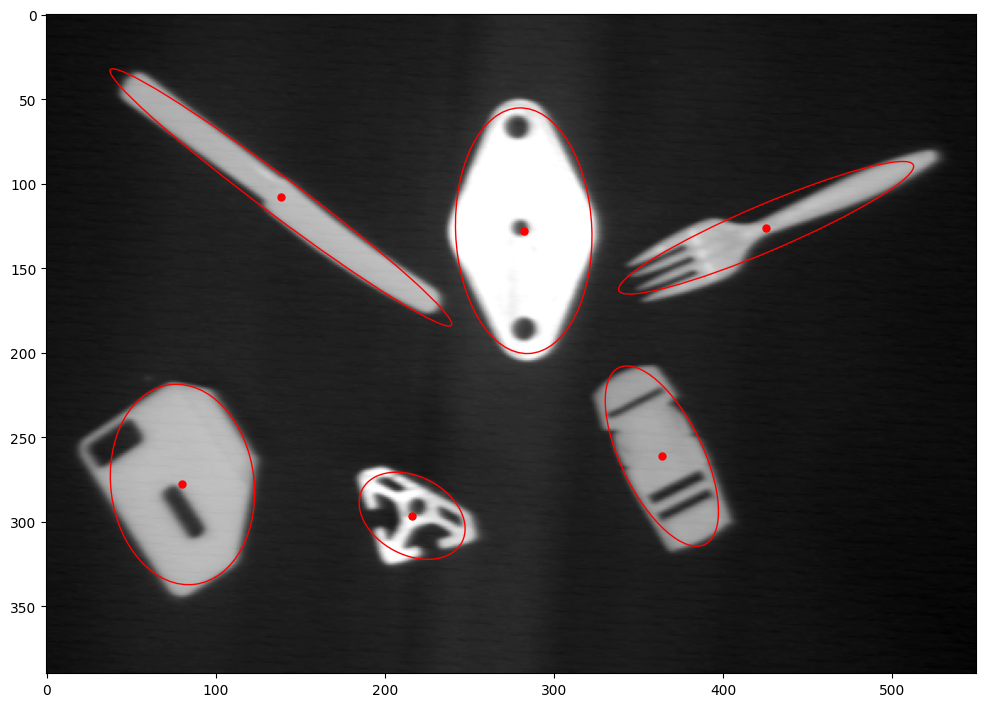

In [6]:
from matplotlib.patches import Ellipse


def calculate_geometric_attributes(label_img, label):
    """Find the geometric attributes of an object in a labeled image.
    
    The origin of the coordinate system is at the top left corner of the image.
    The x axis points to the right. The y axis points down.
    
    Args:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    - label: Label of the object for which we want to calculate the geometric
        attributes.
        
    Returns:
    - cx, cy: xy coordinates of the object center.
    - theta: Orientation of the object in radians.
    - emin, emax: Second moments of the object.
    """
    # TODO
    ys, xs = np.where(label_img == label)  
    cx = xs.mean()  
    cy = ys.mean()  
    
    x_centred = xs - cx
    y_centred = ys - cy
    
    a = (x_centred**2).sum()
    b = 2 * (x_centred * y_centred).sum()  
    c = (y_centred**2).sum()
    
    
    theta = 0.5 * np.arctan2(b, a - c)
    
    t = np.sqrt((a - c)**2 + b**2)
    emin = 0.5 * ((a + c) - t)  
    emax = 0.5 * ((a + c) + t)  
    return cx, cy, theta, emin, emax

    
plt.imshow(img, cmap='gray')
labels = [l for l in np.unique(label_img) if l]
for label in labels:
    cx, cy, t, e1, e2 = calculate_geometric_attributes(label_img, label)
    
    plt.plot(cx, cy, marker='o', markersize=5, color=(1,0,0))
    
    ew = 2 * ((4/np.pi)**(1/4)) * (e1**(-1/8)) * (e2**(3/8))
    eh = ew * np.sqrt(e1 / e2)
    plt.gca().add_patch(Ellipse((cx, cy), ew, eh, t*180/np.pi,
        facecolor='none', edgecolor=(1,0,0), linewidth=1))
plt.show()

## 2. Hough Transform

In this example you will implement the Hough transform to find coins in the sample image below.

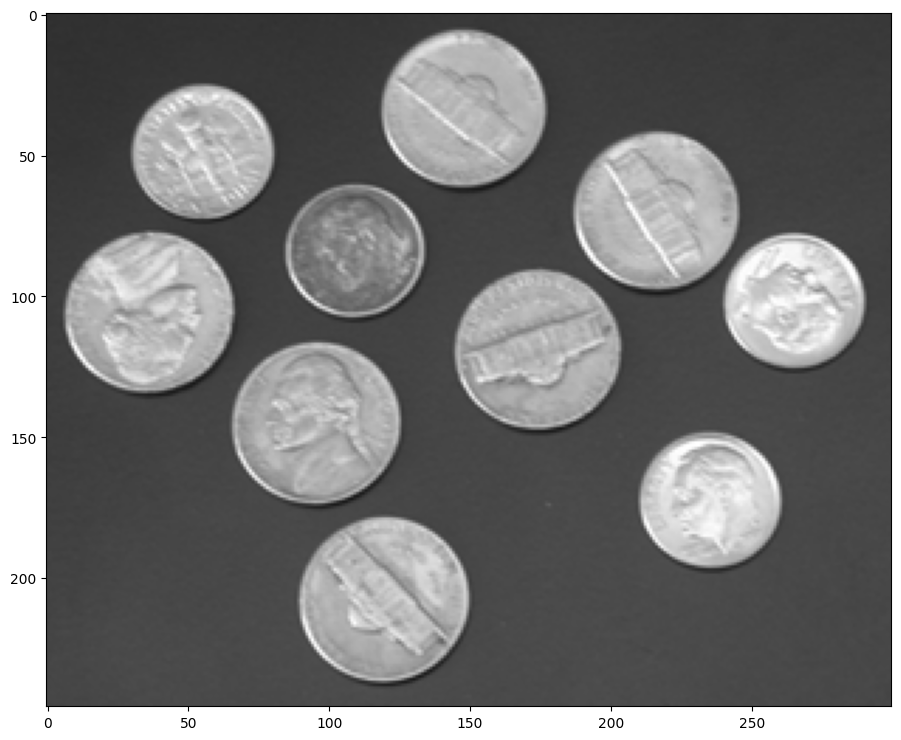

In [7]:
img = cv2.imread('data/coins.png')
plt.imshow(img, cmap='gray')
plt.show()

### 2a. Edge Detection (10 points)

Detect edges in the sample image. Since you have implemented edge detection from scratch in the weekly notebook, here you can simply call `cv2.Canny()`. Pick your threshold values carefully so the edges of the coins are detected.

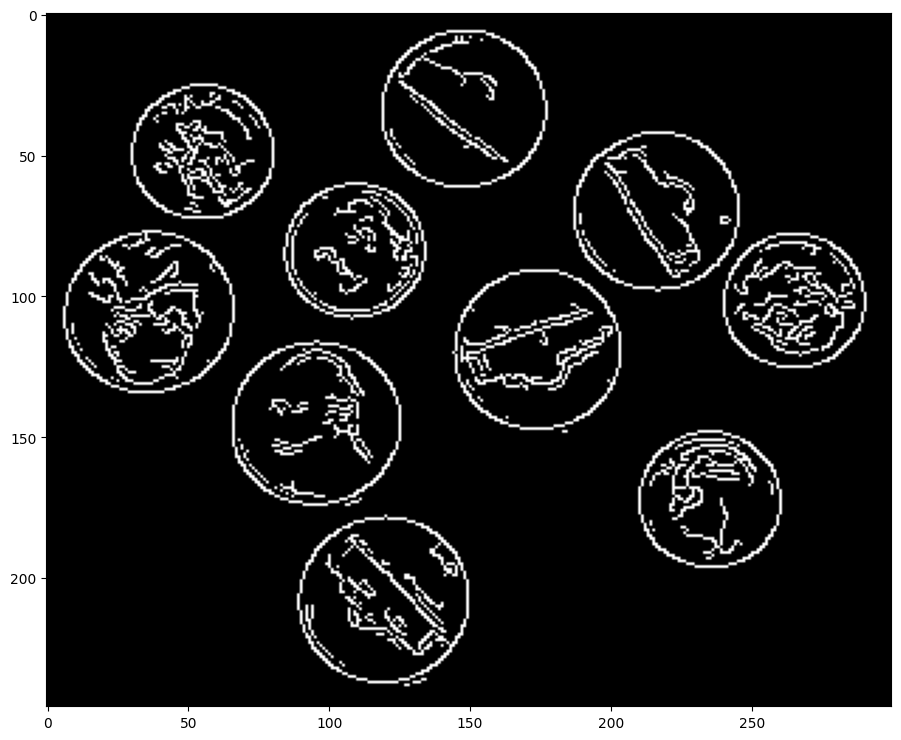

In [8]:
edge_img = cv2.Canny(img, 100, 200)
plt.imshow(edge_img, cmap='gray')
plt.show()

### 2b. Hough Transform (30 points)

Implement the following function to detect circles using the Hough transform. The function should return the accumulator array instead of a list of circles.

For simplicity, your implementation can assume that all circles will be fully inside the image and will not be clipped by the image boundary.

In [9]:
def hough_circles(edge_img, radii):
    """Find circles in an image containing edge pixels.
    
    Args:
    - edge_img: H x W uint8 edge image where 0 indictes non-edge pixels
        whereas 255 indicates edge pixels.
    - radii: A list of R radius values. Only circles whose radius is in this
        list will be found.
    
    Returns:
    - score_map: R x W x H accumulator array. `score_map[r_idx, y, x]`
        represents the total votes received by the circle of radius
        radii[r_idx] centered at pixel `edge_img[y, x]`.
    """
    # TODO
    H, W = edge_img.shape
    num_radii = len(radii)
    score_map = np.zeros((num_radii, H, W))
    edge_points = np.argwhere(edge_img)

    for radius_index, radius in enumerate(radii):
        for edge_y, edge_x in edge_points:
            for angle_degrees in range(360):  
                delta_x = radius * np.cos(np.radians(angle_degrees))
                delta_y = radius * np.sin(np.radians(angle_degrees))
                center_x = int(edge_x - delta_x)
                center_y = int(edge_y - delta_y)
                if 0 <= center_x < W and 0 <= center_y < H:
                    score_map[radius_index, center_y, center_x] += 1
    return score_map

radii = np.arange(25., 31.)
score_map = hough_circles(edge_img, radii)

Visualize the score map (accumulator array) corresponding to `radii[0]`.

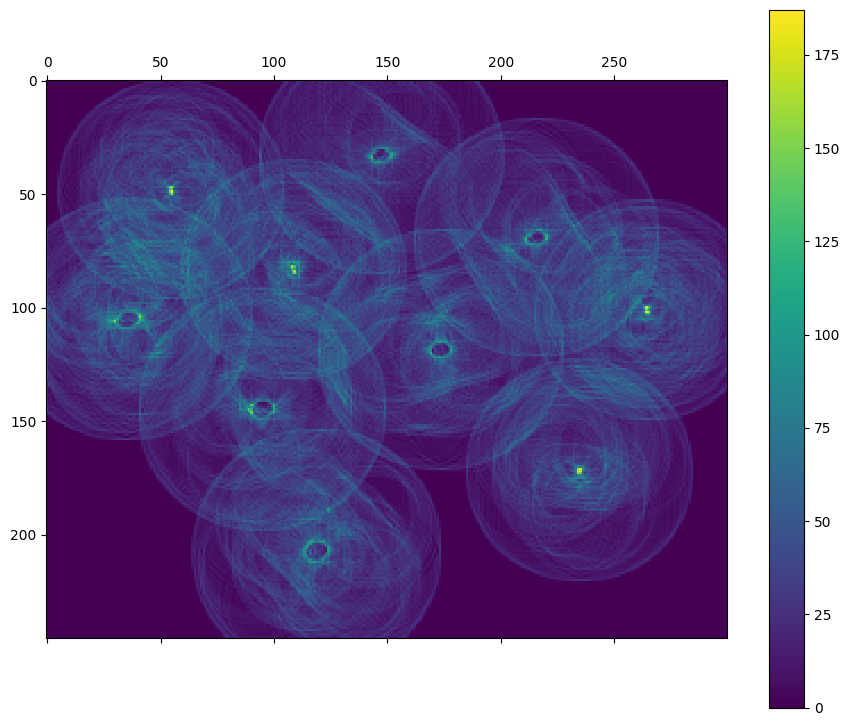

In [10]:
plt.matshow(score_map[0])
plt.colorbar()
plt.show()

From the accumulator array, pick the top scoring circles and display them. It is fine (and expected) if you detect multiple circles for a single coin. We will address this in the next section.

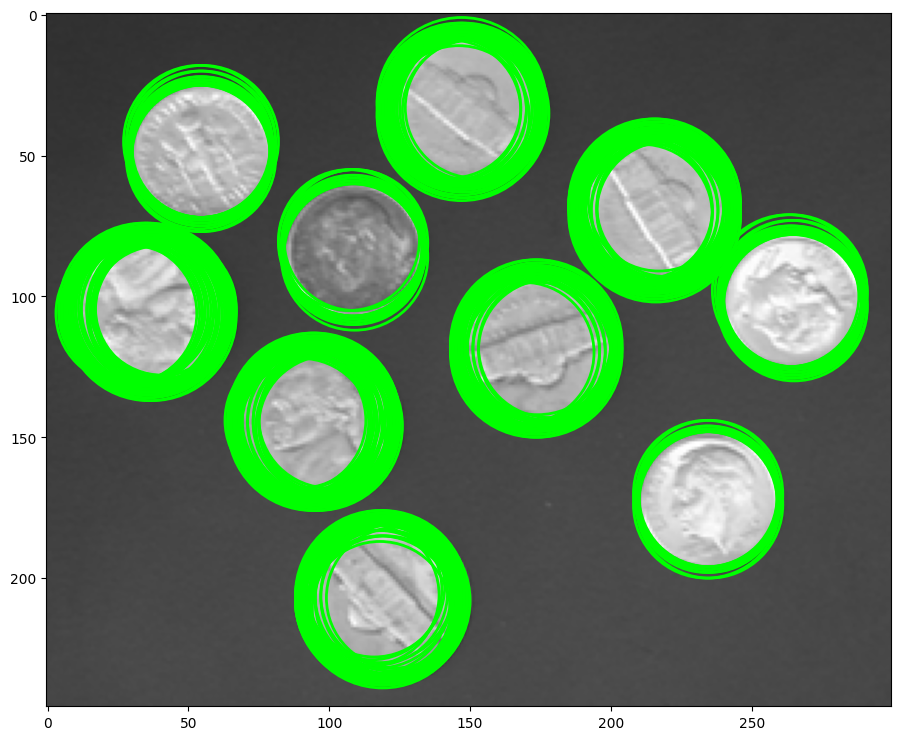

In [11]:
from matplotlib.patches import Circle

plt.imshow(img, cmap='gray')
ris, ys, xs = np.where(score_map > 100)
for ri, y, x in zip(ris, ys, xs):
    r = radii[ri]
    plt.gca().add_patch(Circle((x, y), r, facecolor='none', edgecolor=(0,1,0), linewidth=2))
plt.show()

### 2c. Non-Maximum Suppression (10 points)

You may have observed that your results in the last section contain duplicate detections if you want to detect all coins. This is quite common in detection systems including the neural network detectors that we will cover in the second half of this course. A post-processing step called non-maximum suppression is often needed to remove these duplicate detections. In our case, if two circles overlap with each other too much, we can assume they are duplicate detections and discard the one with lower votes. For the entire list of detections, we could sort them based on votes and repeat this process to suppress duplicate detections.

In the cell below, implement this process and plot the results after post-processing. The final results should contain all coins without duplicates.

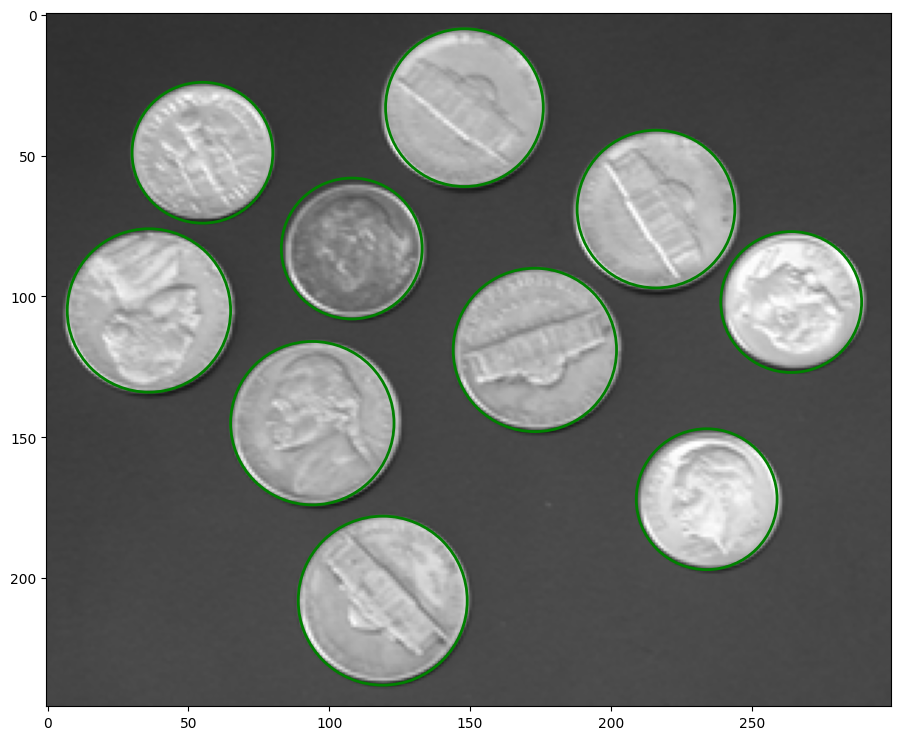

In [12]:
# TODO
def apply_nms_to_circles(score_map, radii, distance_threshold=5, minimum_score_ratio=0.5):
    """
    Reduces the number of detected circles by applying Non-Maximum Suppression (NMS).

    Args:
    - score_map: Accumulator array from the Hough Transform, shape [R, H, W].
    - radii: List of radii for the circles.
    - distance_threshold: Max distance to suppress nearby weaker circles.
    - minimum_score_ratio: Minimum score as a fraction of the highest score to keep a circle.

    Returns:
    - A list of tuples (radius_index, center_y, center_x) for the circles after NMS.
    """
    potential_circles = []
    num_radii, height, width = score_map.shape
    threshold_score = np.max(score_map) * minimum_score_ratio
    
    for radius_index, _ in enumerate(radii):
        for y in range(height):
            for x in range(width):
                if score_map[radius_index, y, x] >= threshold_score:
                    neighborhood = score_map[max(0, radius_index-1):min(num_radii, radius_index+2),
                                             max(0, y-distance_threshold):min(height, y+distance_threshold+1),
                                             max(0, x-distance_threshold):min(width, x+distance_threshold+1)]
                    if score_map[radius_index, y, x] == np.max(neighborhood):
                        potential_circles.append((radius_index, y, x))

    final_circles = merge_close_circles(potential_circles, radii, distance_threshold)

    plot_circles(final_circles, radii)

    return final_circles

def merge_close_circles(circles, radii, merge_distance):
    """
    Merges circles that are within a specified distance of each other.

    Args:
    - circles: List of tuples (radius_index, center_y, center_x) representing circles.
    - radii: List of radii for the circles.
    - merge_distance: Distance within which to merge circles.

    Returns:
    - List of merged circles as tuples (radius_index, center_y, center_x).
    """
    if not circles:
        return []

    circles = np.array(circles)
    merged_circles = []

    while len(circles):
        circle = circles[0]
        distances = np.linalg.norm(circles[:, 1:] - circle[1:], axis=1)
        close_by = distances < merge_distance
        if np.any(close_by):
            merged_circle = np.mean(circles[close_by], axis=0).astype(int)
            merged_circles.append(tuple(merged_circle))
            circles = circles[~close_by]
        else:
            merged_circles.append(tuple(circle))
            circles = circles[1:]

    return merged_circles

def plot_circles(circles, radii):
    """
    Plots detected circles on the original image.

    Args:
    - circles: List of tuples (radius_index, center_y, center_x) for circles.
    - radii: List of radii for the circles.
    """
    plt.imshow(img, cmap='gray') 
    for radius_index, center_y, center_x in circles:
        radius = radii[radius_index]
        circle_patch = Circle((center_x, center_y), radius, fill=False, edgecolor='green', linewidth=2)
        plt.gca().add_patch(circle_patch)
    plt.show()

detected_circles = apply_nms_to_circles(score_map, radii, minimum_score_ratio=0.7)